# **MACHINE LEARNING: predicting prices that properties will be sold for**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from itertools import combinations

In [ ]:
df_sold_listings_all_ML = pd.read_csv("/content/df_sold_listings_ML.csv")

In [ ]:
df_sold_listings_all_ML.columns

Index(['dateSold', 'propertyType', 'lotAreaValue', 'address', 'zestimate',
       'imgSrc', 'price', 'bedrooms', 'longitude', 'latitude', 'zpid',
       'rentZestimate', 'bathrooms', 'livingArea', 'country', 'lotAreaUnit',
       'hasImage', 'unit', 'month_year', 'price per sqft', 'geometry',
       'neighborhood', 'group'],
      dtype='object')

In [ ]:
#When trying to run k-nearest neighbors, run into an error since 77 properties have bedrooms value of NaN, drop these
df_sold_listings_all_ML.dropna(subset=['bedrooms'], inplace=True)

In [ ]:
#When trying to run k-nearest neighbors, run into an error since 1 property with bedrooms value of NaN, drop these
df_sold_listings_all_ML.dropna(subset=['bathrooms'], inplace=True)

In [ ]:
#There is another price per sqft outlier, remove it
top_10 = df_sold_listings_all_ML.nlargest(10, 'price per sqft')

pd.DataFrame(top_10).sort_values(by='price per sqft', ascending= False)

,dateSold,propertyType,lotAreaValue,address,zestimate,imgSrc,price,bedrooms,longitude,latitude,...,livingArea,country,lotAreaUnit,hasImage,unit,month_year,price per sqft,geometry,neighborhood,group
2067,2023-01-13 08:00:00,APARTMENT,NaN,"615 Rolph St, San Francisco, CA 94112",NaN,https://photos.zillowstatic.com/fp/b98345d086b...,1170000,0.0,-122.432250,37.711735,...,150.0,USA,NaN,True,NaN,1/2023,7800.000000,POINT (-122.43225 37.711735),Crocker-Amazon,high_price_low_freq
591,2022-11-07 08:00:00,SINGLE_FAMILY,7661.0000,"3355 Pacific Ave, San Francisco, CA 94118",24611000.0,https://maps.googleapis.com/maps/api/staticmap...,29500000,6.0,-122.450325,37.791092,...,9081.0,USA,sqft,NaN,NaN,11/2022,3248.540910,POINT (-122.450325 37.791092),Presidio Heights,high_price_low_freq
1945,2023-01-31 08:00:00,CONDO,NaN,"2121 Webster St APT 605, San Francisco, CA 94115",6466700.0,https://photos.zillowstatic.com/fp/92e5ddf8853...,6500000,3.0,-122.433174,37.790268,...,2145.0,USA,NaN,True,Apt 605,1/2023,3030.303030,POINT (-122.433174 37.790268),Pacific Heights,high_price_low_freq
1910,2023-02-03 08:00:00,CONDO,6875.0000,"1958 Vallejo St APT 11, San Francisco, CA 94123",8359300.0,https://photos.zillowstatic.com/fp/4aff4f8cc9b...,8400000,4.0,-122.429520,37.796223,...,2920.0,USA,sqft,True,Apt 11,2/2023,2876.712329,POINT (-122.42952 37.796223),Pacific Heights,high_price_low_freq
1919,2023-02-03 08:00:00,CONDO,1.0853,"2121 Webster St APT 507, San Francisco, CA 94115",4955900.0,https://photos.zillowstatic.com/fp/8a2e41e1750...,4980000,2.0,-122.433174,37.790268,...,1940.0,USA,acres,True,Apt 507,2/2023,2567.010309,POINT (-122.433174 37.790268),Pacific Heights,high_price_low_freq
199,2023-01-20 08:00:00,SINGLE_FAMILY,NaN,"1515 Union St #6A, San Francisco, CA 94123",5275700.0,https://maps.googleapis.com/maps/api/staticmap...,6000000,3.0,-122.424300,37.798183,...,2362.0,USA,NaN,NaN,# 6A,1/2023,2540.220152,POINT (-122.4243 37.798183),unknown,high_price_high_freq
2011,2023-01-20 08:00:00,SINGLE_FAMILY,NaN,"1515 Union St #6A, San Francisco, CA 94123",5275700.0,https://maps.googleapis.com/maps/api/staticmap...,6000000,3.0,-122.424300,37.798183,...,2362.0,USA,NaN,NaN,# 6A,1/2023,2540.220152,POINT (-122.4243 37.798183),unknown,high_price_high_freq
131,2023-02-14 08:00:00,SINGLE_FAMILY,9962.0000,"2 Everson St, San Francisco, CA 94131",6669800.0,https://photos.zillowstatic.com/fp/e03d3661d78...,8700000,4.0,-122.429436,37.738800,...,3542.0,USA,sqft,True,NaN,2/2023,2456.239413,POINT (-122.429436 37.7388),Fairmount,high_price_high_freq
1821,2023-02-14 08:00:00,SINGLE_FAMILY,9962.0000,"2 Everson St, San Francisco, CA 94131",6669800.0,https://photos.zillowstatic.com/fp/e03d3661d78...,8700000,4.0,-122.429436,37.738800,...,3542.0,USA,sqft,True,NaN,2/2023,2456.239413,POINT (-122.429436 37.7388),Fairmount,high_price_high_freq
2054,2023-01-17 08:00:00,CONDO,0.0000,"301 Mission St APT 54B, San Francisco, CA 94105",7702900.0,https://photos.zillowstatic.com/fp/f067f533f6d...,7750000,2.0,-122.395930,37.790543,...,3315.0,USA,sqft,True,Apt 54B,1/2023,2337.858220,POINT (-122.39593 37.790543),SoMa,high_price_low_freq


In [ ]:
# Find the index of the row with the specified address
idx_to_drop = df_sold_listings_all_ML.index[df_sold_listings_all_ML['address'] == '615 Rolph St, San Francisco, CA 94112'][0]

# Drop the row using the index
df_sold_listings_all_ML = df_sold_listings_all_ML.drop(idx_to_drop)

In [ ]:
#There is another price per sqft outlier, remove it
top_10 = df_sold_listings_all_ML.nlargest(10, 'price')

In [ ]:
# There is another outlier at price of $29.5M, find the index of the row with the specified address
idx_to_drop = df_sold_listings_all_ML.index[df_sold_listings_all_ML['address'] == '3355 Pacific Ave, San Francisco, CA 94118'][0]

# Drop the row using the index
df_sold_listings_all_ML = df_sold_listings_all_ML.drop(idx_to_drop)

I am trying to predict price, a quantitative variable, so will be using regression models.

# **K-Nearest neighbors**

The features that I will be using for the ML models are: propertyType, bedrooms, bathrooms, livingArea, price per sqft, and group. I will explore the combination of features to see which ones will produce the best model.

In [ ]:
features = list(df_sold_listings_all_ML.columns.drop(["dateSold", "lotAreaValue", "zestimate", "imgSrc", "longitude", "latitude", "zpid", "rentZestimate", "country", "lotAreaUnit", "hasImage", "unit", "month_year", "geometry", "neighborhood", "address", "price", "price per sqft", "group"]))
cat_vars = ["propertyType"]
quant_vars = [f for f in features if f not in cat_vars]
base_features = cat_vars
misc_features = quant_vars.copy()

y_train = df_sold_listings_all_ML["price"]

In [ ]:
features

['propertyType', 'bedrooms', 'bathrooms', 'livingArea']

In [ ]:
X_train = df_sold_listings_all_ML[features]

# Column transformer for specified features
transformer = make_column_transformer(
    (StandardScaler(), quant_vars),
    (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    remainder="passthrough"
)

pipeline = make_pipeline(
    transformer,
    KNeighborsRegressor(n_neighbors=20, metric="euclidean")
)

clf = GridSearchCV(pipeline,
                   param_grid={
                       "kneighborsregressor__n_neighbors": range(1, 20)
                       },
                   scoring="neg_mean_squared_error",
                   cv=10)
clf.fit(X_train, y_train)
clf.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'livingArea']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['propertyType'])])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=7))])

7     636671.990210
10    638786.112222
dtype: float64

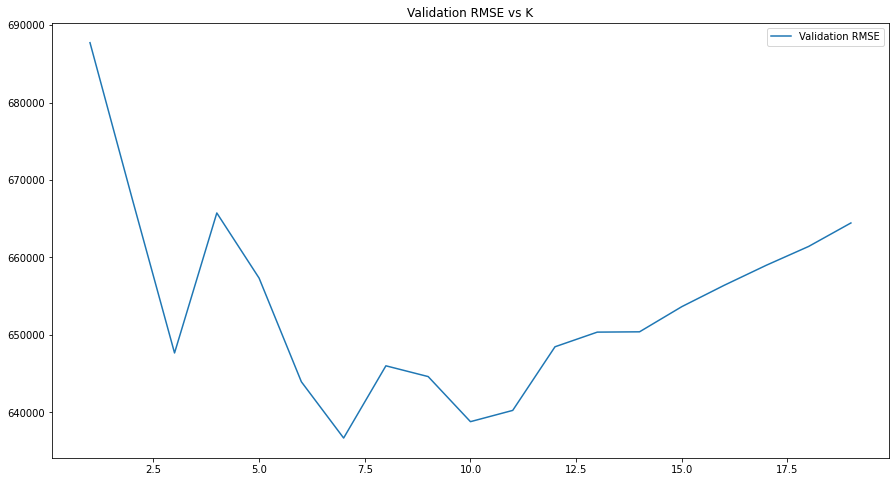

In [ ]:
results = clf.cv_results_

# Get a series containing the RMSE for each k
cv_rmse = pd.Series(
            np.sqrt(-results["mean_test_score"]),
            index=results["param_kneighborsregressor__n_neighbors"]
            )

cv_rmse.plot.line(legend=True, label="Validation RMSE", figsize=(15, 8), title="Validation RMSE vs K")
cv_rmse.sort_values().head(2)

K=2, seems to produce the lowest RMSE error

In [ ]:
#explore feature combinations
misc_feat_combos = [[]]

# Get all combinations of features
for r in range(1, len(misc_features) + 1):
  misc_feat_combos.extend(list(combinations(misc_features, r)))

# Convert all into list of list of features
for i in range(len(misc_feat_combos)):
  misc_feat_combos[i] = list(misc_feat_combos[i])


In [ ]:
def try_diff_features(model):
  rmse_series = pd.Series()

  for feat_combo in misc_feat_combos:
    ct = make_column_transformer(
        (StandardScaler(), feat_combo),
        (OneHotEncoder(handle_unknown="ignore"), cat_vars),
        remainder="passthrough"
    )

    pipeline = make_pipeline(ct, model)
    train_features = base_features + feat_combo
    cv_errs = -cross_val_score(pipeline,
                                X=df_sold_listings_all_ML[train_features],
                                y=y_train,
                                scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(cv_errs.mean())
    rmse_series[str(feat_combo)] = rmse

  return rmse_series


In [ ]:
knearest_rmse_misc = try_diff_features(KNeighborsRegressor(n_neighbors=1, metric="euclidean"))
knearest_rmse_misc.sort_values()

<ipython-input-15-4b400373af70>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse_series = pd.Series()


['bedrooms', 'livingArea']                 6.097057e+05
['bathrooms', 'livingArea']                6.555111e+05
['bedrooms', 'bathrooms', 'livingArea']    6.877355e+05
['livingArea']                             6.994049e+05
[]                                         1.019042e+06
['bathrooms']                              1.081944e+06
['bedrooms', 'bathrooms']                  1.087147e+06
['bedrooms']                               1.099451e+06
dtype: float64

In [ ]:
# Keep track of model
models = {
    "Model Name" : [],
    "Validation RSME" : [],
    "Test RSME" : [],
    "Features" : [],
    "Model" : []
}

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    (StandardScaler(), quant_vars),
    remainder="passthrough"
)

best_knearest = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=7, metric="euclidean")
)

models["Model Name"].append("KNearestNeighbors")
models["Validation RSME"].append(knearest_rmse_misc.min())
models["Features"].append(features)
models["Model"].append(best_knearest)

# **LINEAR REGRESSION**

In [ ]:
linear_rmse_misc = try_diff_features(LinearRegression())
linear_rmse_misc.sort_values()

<ipython-input-15-4b400373af70>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse_series = pd.Series()


['bedrooms', 'bathrooms', 'livingArea']    6.581671e+05
['bedrooms', 'livingArea']                 6.645577e+05
['livingArea']                             6.807191e+05
['bathrooms', 'livingArea']                6.808174e+05
['bedrooms', 'bathrooms']                  8.440953e+05
['bathrooms']                              8.447665e+05
['bedrooms']                               9.302338e+05
[]                                         1.005718e+06
dtype: float64

In [ ]:
best_linear = make_pipeline(
      ct,
      LinearRegression()
)

models["Model Name"].append("LinearRegression")
models["Validation RSME"].append(linear_rmse_misc.min())
models["Features"].append(features)
models["Model"].append(best_linear)

# **Random Forrest Regression**

In [ ]:
random_forest_rmse_misc = try_diff_features(RandomForestRegressor())
random_forest_rmse_misc.sort_values()

<ipython-input-15-4b400373af70>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rmse_series = pd.Series()


['bedrooms', 'livingArea']                 5.588518e+05
['bedrooms', 'bathrooms', 'livingArea']    5.819141e+05
['livingArea']                             5.869841e+05
['bathrooms', 'livingArea']                5.916083e+05
['bedrooms', 'bathrooms']                  8.080787e+05
['bathrooms']                              8.414364e+05
['bedrooms']                               9.157484e+05
[]                                         1.005952e+06
dtype: float64

In [ ]:
best_rf = make_pipeline(
    ct,
    (RandomForestRegressor())
)

models["Model Name"].append("Random Forest")
models["Validation RSME"].append(random_forest_rmse_misc.min())
models["Features"].append(features)
models["Model"].append(best_rf)

In [ ]:
#read in test data
df_listings_test = pd.read_csv("/content/df_listings_for_sale_All.csv")

In [ ]:
df_listings_test.columns

Index(['dateSold', 'propertyType', 'lotAreaValue', 'address', 'variableData',
       'priceChange', 'zestimate', 'imgSrc', 'price', 'bedrooms',
       'contingentListingType', 'longitude', 'latitude', 'listingStatus',
       'zpid', 'rentZestimate', 'daysOnZillow', 'bathrooms', 'livingArea',
       'country', 'currency', 'lotAreaUnit', 'hasImage',
       'listingSubType.is_FSBA', 'variableData.text', 'variableData.type',
       'listingSubType.is_openHouse', 'newConstructionType',
       'listingSubType.is_newHome', 'listingSubType.is_bankOwned', 'unit',
       'listingSubType.is_forAuction', 'listingSubType.is_foreclosure'],
      dtype='object')

In [ ]:
df_listings_test.drop(['dateSold', 'lotAreaValue', 'variableData', 'priceChange', 'zestimate', 'imgSrc', 'contingentListingType', 'listingStatus', 'zpid', 'rentZestimate', 'daysOnZillow', 'country', 'currency', 'hasImage', 'listingSubType.is_FSBA', 'variableData.text', 'variableData.type',
       'listingSubType.is_openHouse', 'newConstructionType','listingSubType.is_newHome', 'listingSubType.is_bankOwned', 'unit',
       'listingSubType.is_forAuction', 'listingSubType.is_foreclosure', 'lotAreaUnit', 'longitude', 'latitude', 'address'], axis=1, inplace=True)

In [ ]:
df_listings_test.columns

Index(['propertyType', 'price', 'bedrooms', 'bathrooms', 'livingArea'], dtype='object')

In [ ]:
df_listings_test.dropna(subset=['bedrooms'], inplace=True)
df_listings_test.dropna(subset=['bathrooms'], inplace=True)
df_listings_test.dropna(subset=['livingArea'], inplace=True)

In [ ]:
#predicting the price
y_test_total = df_listings_test["price"]

for i in range(0, len(models["Model Name"])):
  m_features = models["Features"][i]
  X_train = df_sold_listings_all_ML[m_features]
  X_test = df_listings_test[m_features]
  model = models["Model"][i]
  model.fit(X=X_train, y=y_train)
  y_test_ = model.predict(X_test)
  models["Test RSME"].append(np.sqrt(mean_squared_error(y_test_total, y_test_)))

In [ ]:
used_models = models["Model"]
del models["Model"], models["Features"]
pd.DataFrame(models)

,Model Name,Validation RSME,Test RSME
0,KNearestNeighbors,609705.727950,3.287983e+06
1,LinearRegression,658167.144484,2.975862e+06
2,Random Forest,558851.778153,2.999634e+06


LinearRegression has the bset Test RSME, while random_forest has the best validation RSME. Over these RSME's seem really high, further model tuning is warranted.